In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from src.smoothing import bspline_smoothing, bspline_smoothing_MAF, evaluate_spline
import seaborn as sns

In [2]:
lrtt_data = pd.read_csv('./data/derived/lrtt_data_for_classifier.csv')
maf_data = pd.read_csv('./data/derived/computed_MAF_data.csv')

In [ ]:
manual_knots = [676, 1000, 5000, 6600, 7500, 8000, 9524]

smoothed_data = []

for category in lrtt_data['TSI_category'].unique():
    category_df = lrtt_data[lrtt_data['TSI_category'] == category].copy()
    category_df['mean_lrtt_smoothed'] = bspline_smoothing(category_df, 'xcoord', 'mean_lrtt', t = manual_knots)
    smoothed_data.append(category_df)

smoothed_lrtt = pd.concat(smoothed_data)

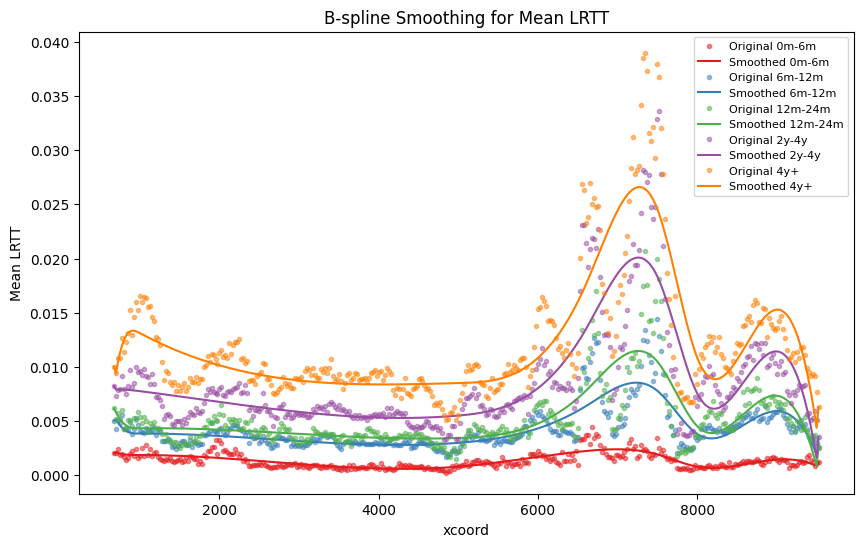

In [37]:
plt.figure(figsize=(10, 6))
palette = sns.color_palette("Set1", n_colors=5)

for i, category in enumerate(smoothed_lrtt['TSI_category'].unique()):
    category_df = smoothed_lrtt[smoothed_lrtt['TSI_category'] == category]
    plt.plot(category_df['xcoord'], category_df['mean_lrtt'], 'o', markersize=3, label=f'Original {category}', color=palette[i], alpha = 0.5)
    plt.plot(category_df['xcoord'], category_df['mean_lrtt_smoothed'], '-', label=f'Smoothed {category}', color=palette[i])

plt.xlabel('xcoord')
plt.ylabel('Mean LRTT')
plt.legend(loc = 'upper right', fontsize = 8)
plt.title('B-spline Smoothing for Mean LRTT')
plt.savefig('./outputs/smoothed_lrtt.png')
plt.show()


In [33]:
#Save as csv
smoothed_lrtt.to_csv('./data/derived/smoothed_lrtt_data.csv', index=False)

## MAF Smoothing

In [27]:
smoothed_maf_data = []
manual_knots = [1100, 5000, 6600, 7500, 8200, 9500]

for category in maf_data['TSI_category'].unique():
    category_maf_df = maf_data[maf_data['TSI_category'] == category].copy()
    category_maf_df['maf12c_smoothed'] = bspline_smoothing(category_maf_df, 'Window_Centre', 'MAF12c_Mean', smoothing_factor=1, k=3, t=manual_knots)

    smoothed_maf_data.append(category_maf_df)

smoothed_maf = pd.concat(smoothed_maf_data)

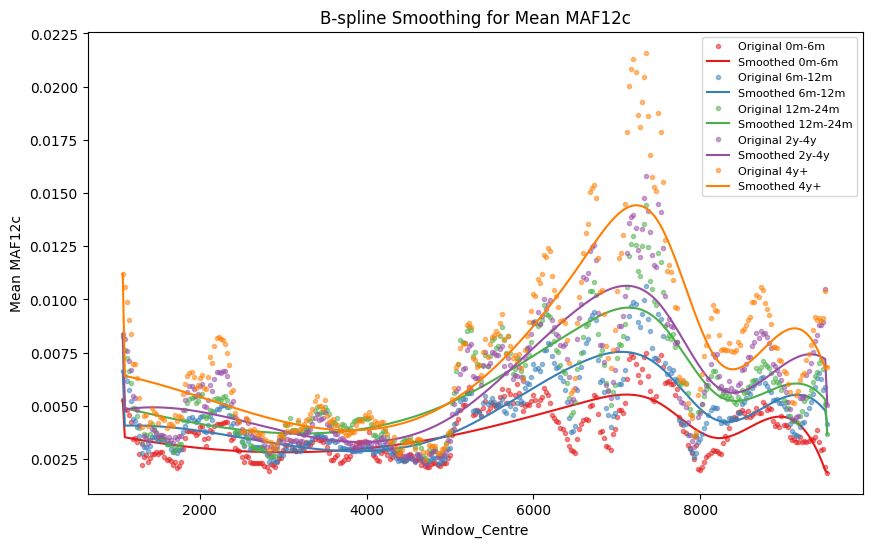

In [28]:
plt.figure(figsize=(10, 6))
palette = sns.color_palette("Set1", n_colors=5)

for i, category in enumerate(smoothed_maf['TSI_category'].unique()):
    category_maf_df = smoothed_maf[smoothed_maf['TSI_category'] == category]
    plt.plot(category_maf_df['Window_Centre'], category_maf_df['MAF12c_Mean'], 'o', markersize=3, label=f'Original {category}', color=palette[i], alpha = 0.5)
    plt.plot(category_maf_df['Window_Centre'], category_maf_df['maf12c_smoothed'], '-', label=f'Smoothed {category}', color=palette[i])

plt.xlabel('Window_Centre')
plt.ylabel('Mean MAF12c')
plt.legend(loc = 'upper right', fontsize = 8)
plt.title('B-spline Smoothing for Mean MAF12c')
plt.savefig('./outputs/smoothed_maf12c.png')
plt.show()


In [ ]:
smoothed_maf_data = []
for category in maf_data['TSI_category'].unique():
    category_maf_df = maf_data[maf_data['TSI_category'] == category].copy()
    
    category_maf_df['maf12c_smoothed'], _ = bspline_smoothing_MAF(
        category_maf_df, 'Window_Centre', 'MAF12c_Mean', 
        smoothing_factor=1, k=3, optimize_knots=True, num_knots=10
    )
    smoothed_maf_data.append(category_maf_df)

smoothed_maf = pd.concat(smoothed_maf_data)

plt.figure(figsize=(10, 6))
palette = sns.color_palette("Set1", n_colors=5)

for i, category in enumerate(smoothed_maf['TSI_category'].unique()):
    category_maf_df = smoothed_maf[smoothed_maf['TSI_category'] == category]
    plt.plot(category_maf_df['Window_Centre'], category_maf_df['MAF12c_Mean'], 'o', markersize=3, label=f'Original {category}', color=palette[i], alpha = 0.5)
    plt.plot(category_maf_df['Window_Centre'], category_maf_df['maf12c_smoothed'], '-', label=f'Smoothed {category}', color=palette[i])

plt.xlabel('Window_Centre')
plt.ylabel('Mean MAF12c')
plt.legend(loc = 'upper right', fontsize = 8)
plt.title('B-spline Smoothing for Mean MAF12c')
plt.savefig('./outputs/smoothed_maf12c.png')
plt.show()

# KEY POINTS
- STARTING POINT: 675 (+1)
- 800
- 5000
- 6600
- 7400/7500
- 8800
- ENDPOINT: 9525 (-1)


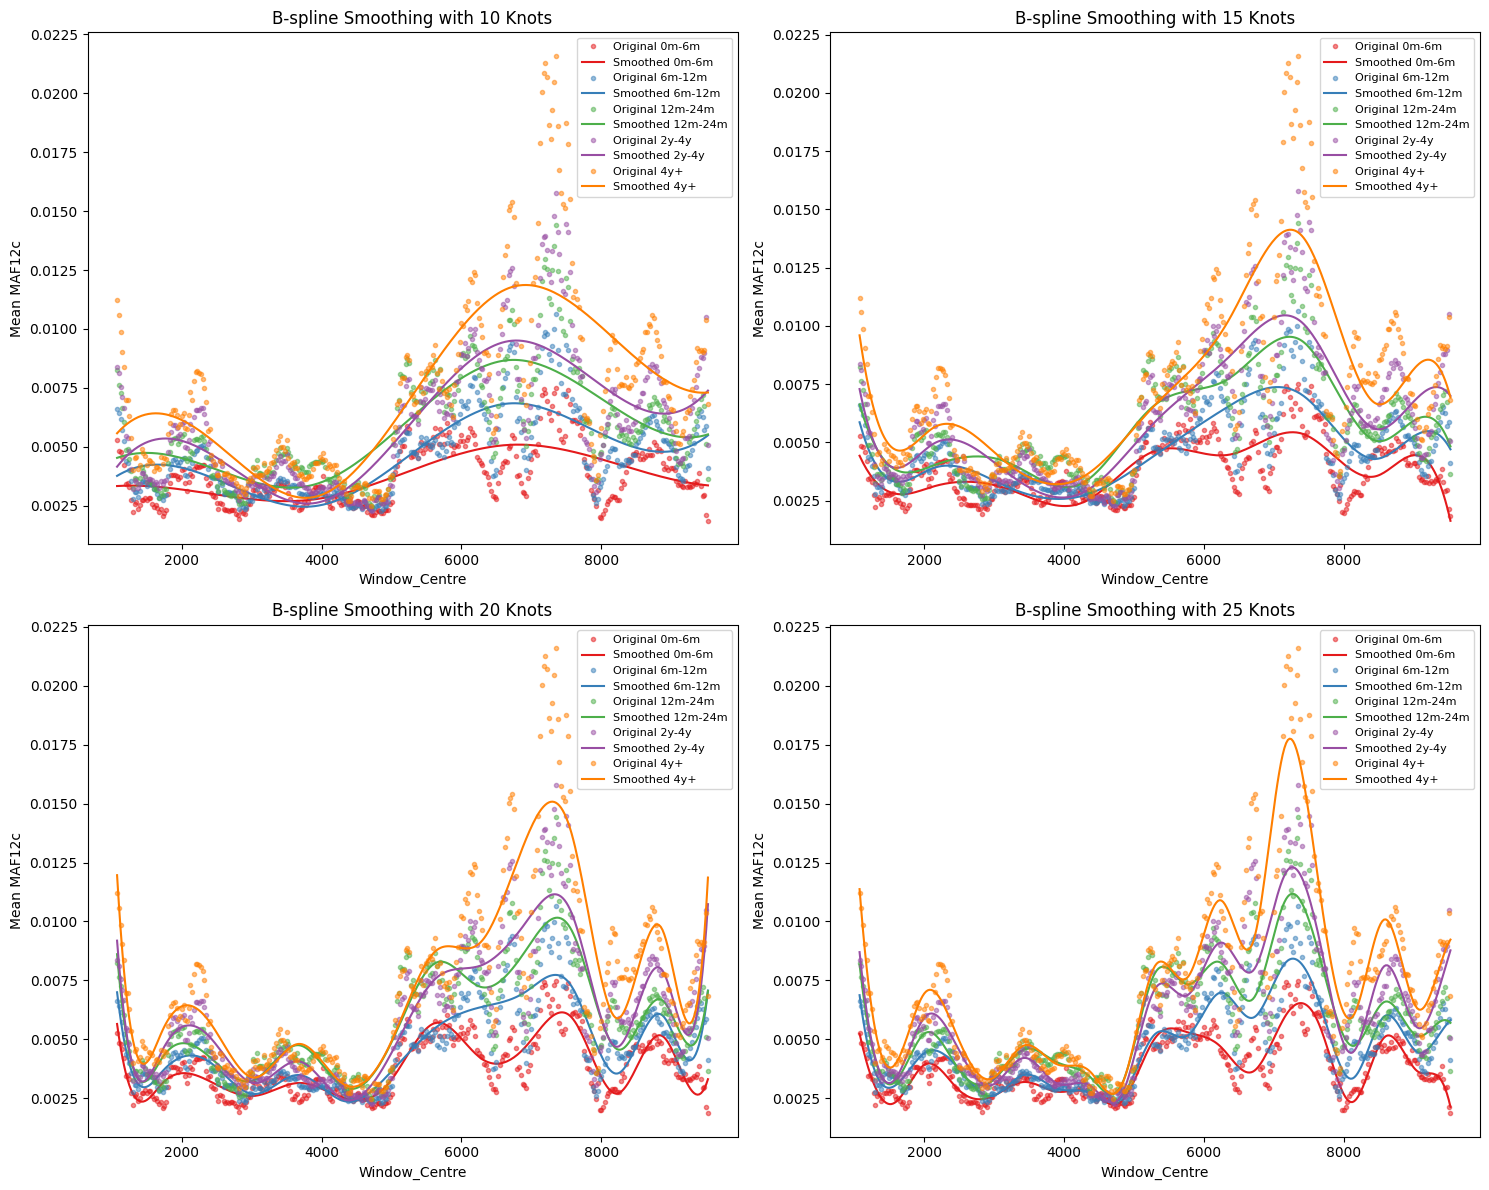

,Num_Knots,MSE,AIC,BIC
0,10,0.000010,-3898.656903,-3860.396902
1,15,0.000009,-3896.964303,-3839.574302
2,20,0.000013,-3788.965425,-3712.445423
3,25,0.000013,-3761.624976,-3665.974973


In [ ]:
knots_list = [10, 15, 20, 25]
knot_placements = {}
results = []

fig, axs = plt.subplots(2, 2, figsize=(15, 12))
palette = sns.color_palette("Set1", n_colors=5)

for j, num_knots in enumerate(knots_list):
    smoothed_maf_data = []
    knots = None

    for category in maf_data['TSI_category'].unique():
        category_maf_df = maf_data[maf_data['TSI_category'] == category].copy()
        
        # Use optimize_knots=True to find the optimal knots
        smoothed_values, knots = bspline_smoothing_MAF(
            category_maf_df, 'Window_Centre', 'MAF12c_Mean', 
            smoothing_factor=1, k=3, t=None, optimize_knots=True, num_knots=num_knots
        )
        category_maf_df['maf12c_smoothed'] = smoothed_values
        smoothed_maf_data.append(category_maf_df)
    
    smoothed_maf = pd.concat(smoothed_maf_data)
    knot_placements[num_knots] = knots
    
    # Evaluate the spline using cross-validation and AIC/BIC
    mse, aic, bic = evaluate_spline(maf_data, 'Window_Centre', 'MAF12c_Mean', num_knots, k=3)
    results.append((num_knots, mse, aic, bic))
    
    # Plotting
    ax = axs[j // 2, j % 2]
    ax.set_title(f'B-spline Smoothing with {num_knots} Knots')
    for i, category in enumerate(smoothed_maf['TSI_category'].unique()):
        category_df = smoothed_maf[smoothed_maf['TSI_category'] == category]
        ax.plot(category_df['Window_Centre'], category_df['MAF12c_Mean'], 'o', markersize=3, label=f'Original {category}', color=palette[i], alpha=0.5)
        ax.plot(category_df['Window_Centre'], category_df['maf12c_smoothed'], '-', label=f'Smoothed {category}', color=palette[i])

    ax.set_xlabel('Window_Centre')
    ax.set_ylabel('Mean MAF12c')
    ax.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.savefig('./outputs/smoothed_maf12c_comparison.png')
plt.show()

results_df = pd.DataFrame(results, columns=['Num_Knots', 'MSE', 'AIC', 'BIC'])
results_df

# MAF3c

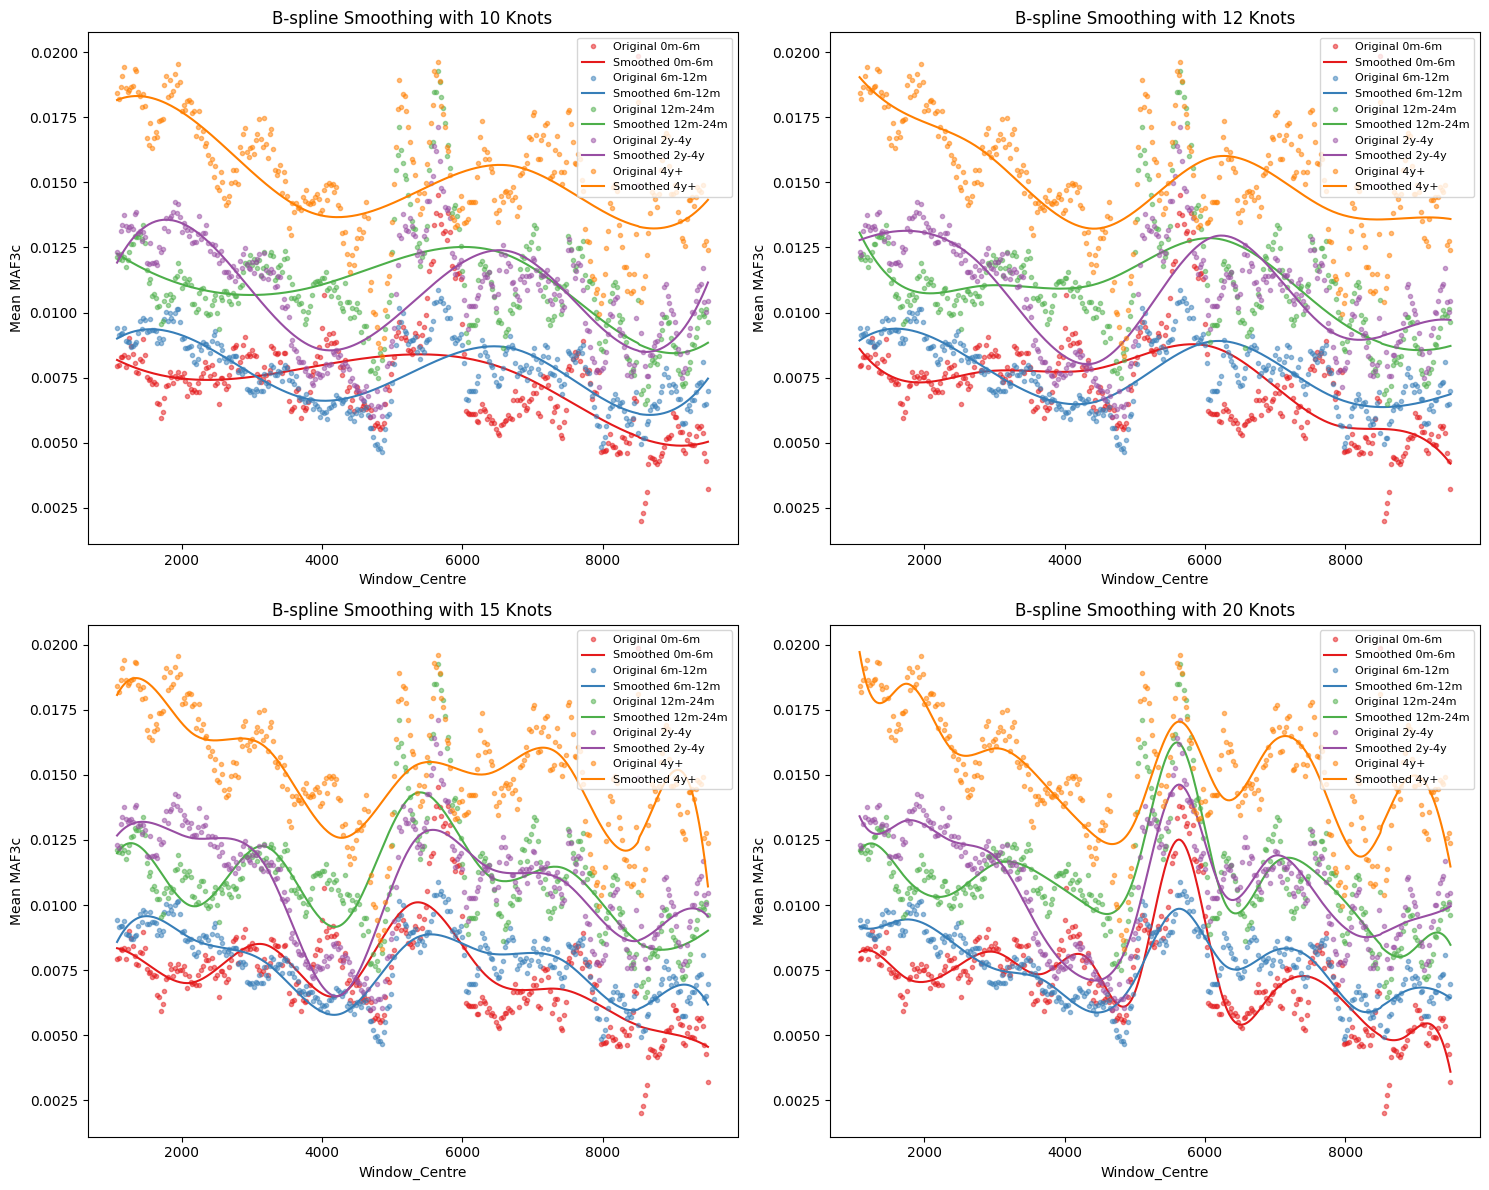

,Num_Knots,MSE,AIC,BIC
0,10,0.000014,-3758.617173,-3720.386749
1,12,0.000015,-3733.914190,-3688.037681
2,15,0.000015,-3728.006929,-3670.661293
3,20,0.000016,-3697.213042,-3620.752194


In [ ]:
knots_list = [10, 12, 15, 20]
knot_placements = {}
results = []

fig, axs = plt.subplots(2, 2, figsize=(15, 12))
palette = sns.color_palette("Set1", n_colors=5)

for j, num_knots in enumerate(knots_list):
    smoothed_maf_data = []
    knots = None

    for category in maf_data['TSI_category'].unique():
        category_maf_df = maf_data[maf_data['TSI_category'] == category].copy()
        
        # Use optimize_knots=True to find the optimal knots
        smoothed_values, knots = bspline_smoothing_MAF(
            category_maf_df, 'Window_Centre', 'MAF3c_Mean', 
            smoothing_factor=1, k=3, t=None, optimize_knots=True, num_knots=num_knots
        )
        category_maf_df = category_maf_df.iloc[:len(smoothed_values)]
        category_maf_df['maf3c_smoothed'] = smoothed_values
        smoothed_maf_data.append(category_maf_df)
    
    
    knot_placements[num_knots] = knots
    smoothed_maf = pd.concat(smoothed_maf_data)

    # Evaluate the spline using cross-validation and AIC/BIC
    mse, aic, bic = evaluate_spline(maf_data, 'Window_Centre', 'MAF3c_Mean', num_knots, k=3)
    results.append((num_knots, mse, aic, bic))
    
    # Plotting
    ax = axs[j // 2, j % 2]
    ax.set_title(f'B-spline Smoothing with {num_knots} Knots')
    for i, category in enumerate(smoothed_maf['TSI_category'].unique()):
        category_maf_df = smoothed_maf[smoothed_maf['TSI_category'] == category]
        ax.plot(category_maf_df['Window_Centre'], category_maf_df['MAF3c_Mean'], 'o', markersize=3, label=f'Original {category}', color=palette[i], alpha=0.5)
        ax.plot(category_maf_df['Window_Centre'], category_maf_df['maf3c_smoothed'], '-', label=f'Smoothed {category}', color=palette[i])

    ax.set_xlabel('Window_Centre')
    ax.set_ylabel('Mean MAF3c')
    ax.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.savefig('./outputs/smoothed_maf3c_comparison.png')
plt.show()

results_df = pd.DataFrame(results, columns=['Num_Knots', 'MSE', 'AIC', 'BIC'])
results_df

## MAF3c with 10 KNOTS

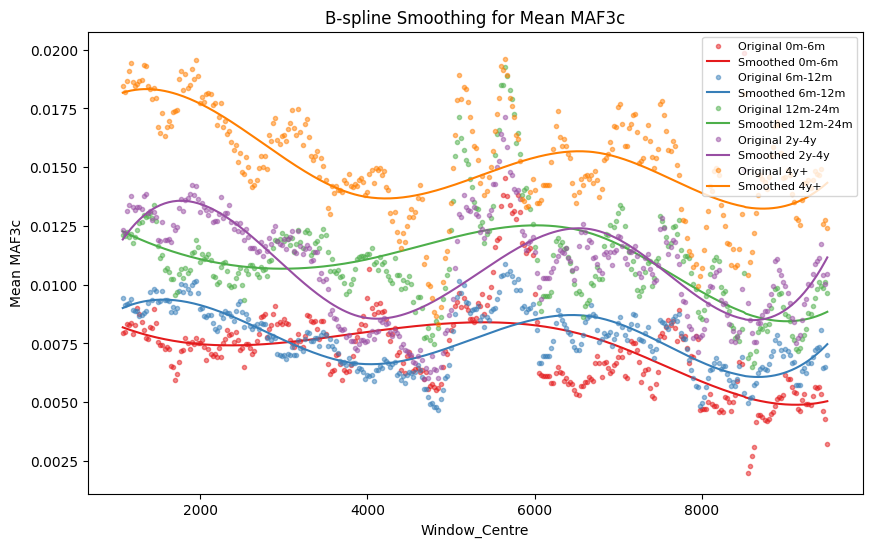

In [7]:
smoothed_maf_data = []
for category in maf_data['TSI_category'].unique():
    category_maf_df = maf_data[maf_data['TSI_category'] == category].copy()
    
    smoothed_values, _ = bspline_smoothing_MAF(
        category_maf_df, 'Window_Centre', 'MAF3c_Mean', 
        smoothing_factor=1, k=3, optimize_knots=True, num_knots=10
    )
    category_maf_df = category_maf_df.iloc[:len(smoothed_values)]
    category_maf_df['maf3c_smoothed'] = smoothed_values
    smoothed_maf_data.append(category_maf_df)

smoothed_maf = pd.concat(smoothed_maf_data)

plt.figure(figsize=(10, 6))
palette = sns.color_palette("Set1", n_colors=5)

for i, category in enumerate(smoothed_maf['TSI_category'].unique()):
    category_maf_df = smoothed_maf[smoothed_maf['TSI_category'] == category]
    plt.plot(category_maf_df['Window_Centre'], category_maf_df['MAF3c_Mean'], 'o', markersize=3, label=f'Original {category}', color=palette[i], alpha = 0.5)
    plt.plot(category_maf_df['Window_Centre'], category_maf_df['maf3c_smoothed'], '-', label=f'Smoothed {category}', color=palette[i])

plt.xlabel('Window_Centre')
plt.ylabel('Mean MAF3c')
plt.legend(loc = 'upper right', fontsize = 8)
plt.title('B-spline Smoothing for Mean MAF3c')
plt.savefig('./outputs/smoothed_maf3c.png')
plt.show()

# COMBINED - MAF

In [6]:
def adjust_lengths(dataframe, smoothed_values):
    if len(smoothed_values) < len(dataframe):
        return dataframe.iloc[:len(smoothed_values)]
    elif len(smoothed_values) > len(dataframe):
        padding = [smoothed_values[-1]] * (len(smoothed_values) - len(dataframe))
        smoothed_values = list(smoothed_values)[:len(dataframe)] + padding
    return dataframe

smoothed_maf_data = []
for category in maf_data['TSI_category'].unique():
    category_maf_df = maf_data[maf_data['TSI_category'] == category].copy()
    
    # Smoothing MAF3c_Mean
    smoothed_values_maf3c, _ = bspline_smoothing_MAF(
        category_maf_df, 'Window_Centre', 'MAF3c_Mean', 
        smoothing_factor=1, k=3, optimize_knots=True, num_knots=10
    )
    
    # Smoothing MAF12c_Mean
    smoothed_values_maf12c, _ = bspline_smoothing_MAF(
        category_maf_df, 'Window_Centre', 'MAF12c_Mean', 
        smoothing_factor=1, k=3, optimize_knots=True, num_knots=10
    )
    min_length = min(len(smoothed_values_maf3c), len(smoothed_values_maf12c), len(category_maf_df))

    category_maf_df = category_maf_df.iloc[:min_length]
    smoothed_values_maf3c = smoothed_values_maf3c[:min_length]
    smoothed_values_maf12c = smoothed_values_maf12c[:min_length]
    
    category_maf_df['maf3c_smoothed'] = smoothed_values_maf3c
    category_maf_df['maf12c_smoothed'] = smoothed_values_maf12c
    
    smoothed_maf_data.append(category_maf_df)

smoothed_maf = pd.concat(smoothed_maf_data)

#save to a CSV file
smoothed_maf.to_csv('./data/derived/smoothed_maf_data.csv', index=False)


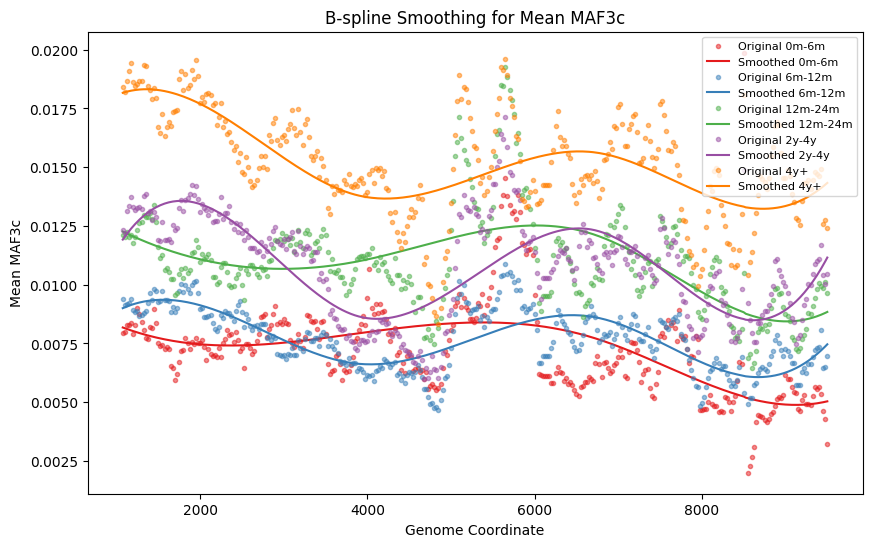

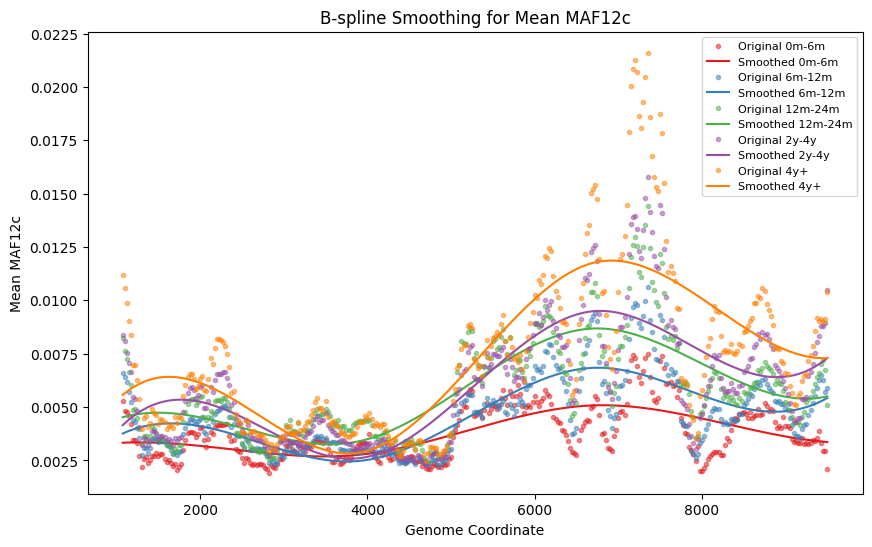

In [7]:
#PLOTTING MAF3c_Mean
plt.figure(figsize=(10, 6))
palette = sns.color_palette("Set1", n_colors=5)

for i, category in enumerate(smoothed_maf['TSI_category'].unique()):
    category_maf_df = smoothed_maf[smoothed_maf['TSI_category'] == category]
    
    plt.plot(category_maf_df['Window_Centre'], category_maf_df['MAF3c_Mean'], 'o', markersize=3, label=f'Original {category}', color=palette[i], alpha=0.5)
    plt.plot(category_maf_df['Window_Centre'], category_maf_df['maf3c_smoothed'], '-', label=f'Smoothed {category}', color=palette[i])

plt.xlabel('Genome Coordinate')
plt.ylabel('Mean MAF3c')
plt.legend(loc='upper right', fontsize=8)
plt.title('B-spline Smoothing for Mean MAF3c')
plt.savefig('./outputs/smoothed_maf3c.png')
plt.show()

#PLOTTING MAF12c_Mean
plt.figure(figsize=(10, 6))
palette = sns.color_palette("Set1", n_colors=5)

for i, category in enumerate(smoothed_maf['TSI_category'].unique()):
    category_maf_df = smoothed_maf[smoothed_maf['TSI_category'] == category]
    
    plt.plot(category_maf_df['Window_Centre'], category_maf_df['MAF12c_Mean'], 'o', markersize=3, label=f'Original {category}', color=palette[i], alpha=0.5)
    plt.plot(category_maf_df['Window_Centre'], category_maf_df['maf12c_smoothed'], '-', label=f'Smoothed {category}', color=palette[i])

plt.xlabel('Genome Coordinate')
plt.ylabel('Mean MAF12c')
plt.legend(loc='upper right', fontsize=8)
plt.title('B-spline Smoothing for Mean MAF12c')
plt.savefig('./outputs/smoothed_maf12c.png')
plt.show()